Notebook for examining the convergence of different $k$-NN divergence estimation methods, different $k$s, and different reference sample sizes.

In [1]:
import numpy as np
from numpy.random import multivariate_normal as mvn 
# -- nonGaussLike -- 
from nongausslike import knn as kNN
from nongausslike import nongauss as NG

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

Lets read in $P_\ell(k)$ data and whiten it up

In [3]:
X_pk = NG.X_pk_all('patchy.z1', NorS='ngc', sys='fc')
X_res, _ = NG.meansub(X_pk)
X_w, W = NG.whiten(X_res)
C_x = np.cov(X_w.T)

In [4]:
n, dim = X_pk.shape
print("%i dimensional data with %i samples" % (dim, n))

37 dimensional data with 2048 samples


In [5]:
# reference Gaussian X 
X_ref = mvn(np.zeros(dim), C_x, size=n)

In [6]:
m_s = [100, 500, 1000, 2000, 3000, 5000]

Lets compare the KL divergences 
$$KL(X_{1:n} || Y_{1:m})$$
estimated using different methods and $k$s as a function of $m$

In [7]:
def Dxy_SKL(X, m, k, div_func='kl', n_sample=10, Cov=C_x): 
    d = X.shape[1]
    _kl = []
    for i in range(n_sample): 
        Y = mvn(np.zeros(d), Cov, size=m)
        _kl.append(NG.kNNdiv_gauss(X, None, Knn=k, div_func=div_func, gauss=Y))
    return _kl 

In [8]:
def KLxy_redBias(X, m, n_sample=10, Cov=C_x): 
    ''' reduced bias Wang et al. (2009) Eq. 29 estimator
    '''
    d = X.shape[1]
    _kl = []
    for i in range(n_sample): 
        Y = mvn(np.zeros(d), Cov, size=m)
        _kl.append(kNN.KL_w2009_eq29(X, Y))
    return _kl 

In [9]:
pkKLxy_skl_k2, pkKLxy_skl_k10, pkKLxy_skl_k15, pkKLxy_redBias = [], [], [], []

for m in m_s: 
    skl_k2 = Dxy_SKL(X_w, m, 2, div_func='kl', n_sample=10, Cov=C_x)
    skl_k10 = Dxy_SKL(X_w, m, 10, div_func='kl', n_sample=10, Cov=C_x)
    skl_k15 = Dxy_SKL(X_w, m, 15, div_func='kl', n_sample=10, Cov=C_x)
    skl_rb = KLxy_redBias(X_w, m, n_sample=10, Cov=C_x)
    
    pkKLxy_skl_k2.append(skl_k2)
    pkKLxy_skl_k10.append(skl_k10)
    pkKLxy_skl_k15.append(skl_k15)    
    pkKLxy_redBias.append(skl_rb)

In [10]:
ref_pkKLxy_skl_k2, ref_pkKLxy_skl_k10, ref_pkKLxy_skl_k15, ref_pkKLxy_redBias = [], [], [], [] 

for m in m_s: 
    skl_k2 = Dxy_SKL(X_ref, m, 2, div_func='kl', n_sample=10, Cov=C_x)
    skl_k10 = Dxy_SKL(X_ref, m, 10, div_func='kl', n_sample=10, Cov=C_x)
    skl_k15 = Dxy_SKL(X_ref, m, 15, div_func='kl', n_sample=10, Cov=C_x)
    skl_rb = KLxy_redBias(X_ref, m, n_sample=10, Cov=C_x)
    
    ref_pkKLxy_skl_k2.append(skl_k2)
    ref_pkKLxy_skl_k10.append(skl_k10)
    ref_pkKLxy_skl_k15.append(skl_k15)    
    ref_pkKLxy_redBias.append(skl_rb)

Text(0,0.5,'$KL(X_{1:n} || Y_{1:m})$')

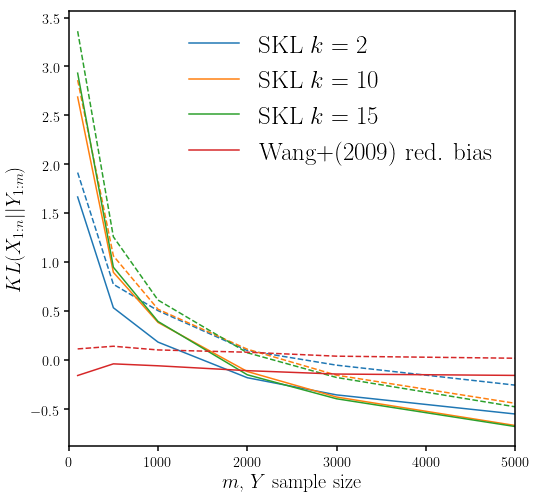

In [11]:
# KL(X||Y) convergence plot for SKL KL estimate
fig = plt.figure(figsize=(8,8))
sub = fig.add_subplot(111)
sub.plot(m_s, [np.average(pkKLxy_skl_k2[i]) for i in range(len(m_s))], c='C0', label='SKL $k=2$')
sub.plot(m_s, [np.average(ref_pkKLxy_skl_k2[i]) for i in range(len(m_s))], c='C0', ls='--')
sub.plot(m_s, [np.average(pkKLxy_skl_k10[i]) for i in range(len(m_s))], c='C1', label='SKL $k=10$')
sub.plot(m_s, [np.average(ref_pkKLxy_skl_k10[i]) for i in range(len(m_s))], c='C1', ls='--')
sub.plot(m_s, [np.average(pkKLxy_skl_k15[i]) for i in range(len(m_s))], c='C2', label='SKL $k=15$')
sub.plot(m_s, [np.average(ref_pkKLxy_skl_k15[i]) for i in range(len(m_s))], c='C2', ls='--')
sub.plot(m_s, [np.average(pkKLxy_redBias[i]) for i in range(len(m_s))], c='C3', label='Wang+(2009) red. bias')
sub.plot(m_s, [np.average(ref_pkKLxy_redBias[i]) for i in range(len(m_s))], c='C3', ls='--')
sub.legend(loc='upper right', fontsize=25)
sub.set_xlabel('$m$, $Y$ sample size', fontsize=20)
sub.set_xlim([0., 5e3])
sub.set_ylabel('$KL(X_{1:n} || Y_{1:m})$', fontsize=20)

Text(0,0.5,'$\\Delta KL(X_{1:n} || Y_{1:m})$')

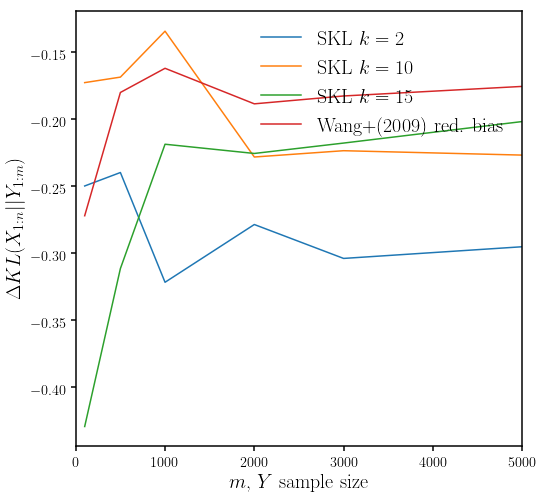

In [12]:
# KL(X||Y) convergence plot for SKL KL estimate
fig = plt.figure(figsize=(8,8))
sub = fig.add_subplot(111)
sub.plot(m_s, [np.average(pkKLxy_skl_k2[i]) - np.average(ref_pkKLxy_skl_k2[i]) for i in range(len(m_s))], c='C0', label='SKL $k=2$')
sub.plot(m_s, [np.average(pkKLxy_skl_k10[i]) - np.average(ref_pkKLxy_skl_k10[i]) for i in range(len(m_s))], c='C1', label='SKL $k=10$')
sub.plot(m_s, [np.average(pkKLxy_skl_k15[i]) - np.average(ref_pkKLxy_skl_k15[i]) for i in range(len(m_s))], c='C2', label='SKL $k=15$')
sub.plot(m_s, [np.average(pkKLxy_redBias[i]) - np.average(ref_pkKLxy_redBias[i]) for i in range(len(m_s))], c='C3', label='Wang+(2009) red. bias')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel('$m$, $Y$ sample size', fontsize=20)
sub.set_xlim([0., 5e3])
sub.set_ylabel('$\Delta KL(X_{1:n} || Y_{1:m})$', fontsize=20)

In [13]:
def Dyx_SKL(X, m, k, div_func='kl', n_sample=10, Cov=C_x): 
    d = X.shape[1]
    _kl = []
    for i in range(n_sample): 
        Y = mvn(np.zeros(d), Cov, size=m)
        _kl.append(NG.kNNdiv_gauss(Y, None, Knn=k, div_func=div_func, gauss=X))
    return _kl 

def KLyx_redBias(X, m, n_sample=10, Cov=C_x): 
    ''' reduced bias Wang et al. (2009) Eq. 29 estimator
    '''
    d = X.shape[1]
    _kl = []
    for i in range(n_sample): 
        Y = mvn(np.zeros(d), Cov, size=m)
        _kl.append(kNN.KL_w2009_eq29(Y, X))
    return _kl 

In [14]:
pkKLyx_skl_k2, pkKLyx_skl_k10, pkKLyx_skl_k15, pkKLyx_redBias = [], [], [], []

for m in m_s: 
    skl_k2 = Dyx_SKL(X_w, m, 2, div_func='kl', n_sample=10, Cov=C_x)
    skl_k10 = Dyx_SKL(X_w, m, 10, div_func='kl', n_sample=10, Cov=C_x)
    skl_k15 = Dyx_SKL(X_w, m, 15, div_func='kl', n_sample=10, Cov=C_x)
    skl_rb = KLyx_redBias(X_w, m, n_sample=10, Cov=C_x)
    
    pkKLyx_skl_k2.append(skl_k2)
    pkKLyx_skl_k10.append(skl_k10)
    pkKLyx_skl_k15.append(skl_k15)    
    pkKLyx_redBias.append(skl_rb)

In [15]:
ref_pkKLyx_skl_k2, ref_pkKLyx_skl_k10, ref_pkKLyx_skl_k15, ref_pkKLyx_redBias = [], [], [], [] 

for m in m_s: 
    skl_k2 = Dyx_SKL(X_ref, m, 2, div_func='kl', n_sample=10, Cov=C_x)
    skl_k10 = Dyx_SKL(X_ref, m, 10, div_func='kl', n_sample=10, Cov=C_x)
    skl_k15 = Dyx_SKL(X_ref, m, 15, div_func='kl', n_sample=10, Cov=C_x)
    skl_rb = KLyx_redBias(X_ref, m, n_sample=10, Cov=C_x)
    
    ref_pkKLyx_skl_k2.append(skl_k2)
    ref_pkKLyx_skl_k10.append(skl_k10)
    ref_pkKLyx_skl_k15.append(skl_k15)    
    ref_pkKLyx_redBias.append(skl_rb)

Text(0,0.5,'$KL(X_{1:n} || Y_{1:m})$')

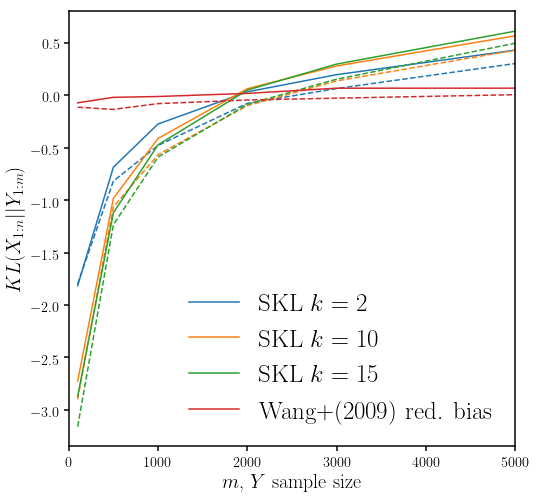

In [16]:
# KL(X||Y) convergence plot for SKL KL estimate
fig = plt.figure(figsize=(8,8))
sub = fig.add_subplot(111)
sub.plot(m_s, [np.average(pkKLyx_skl_k2[i]) for i in range(len(m_s))], c='C0', label='SKL $k=2$')
sub.plot(m_s, [np.average(ref_pkKLyx_skl_k2[i]) for i in range(len(m_s))], c='C0', ls='--')
sub.plot(m_s, [np.average(pkKLyx_skl_k10[i]) for i in range(len(m_s))], c='C1', label='SKL $k=10$')
sub.plot(m_s, [np.average(ref_pkKLyx_skl_k10[i]) for i in range(len(m_s))], c='C1', ls='--')
sub.plot(m_s, [np.average(pkKLyx_skl_k15[i]) for i in range(len(m_s))], c='C2', label='SKL $k=15$')
sub.plot(m_s, [np.average(ref_pkKLyx_skl_k15[i]) for i in range(len(m_s))], c='C2', ls='--')
sub.plot(m_s, [np.average(pkKLyx_redBias[i]) for i in range(len(m_s))], c='C3', label='Wang+(2009) red. bias')
sub.plot(m_s, [np.average(ref_pkKLyx_redBias[i]) for i in range(len(m_s))], c='C3', ls='--')
sub.legend(loc='lower right', fontsize=25)
sub.set_xlabel('$m$, $Y$ sample size', fontsize=20)
sub.set_xlim([0., 5e3])
sub.set_ylabel('$KL(X_{1:n} || Y_{1:m})$', fontsize=20)

Text(0,0.5,'$\\Delta KL(X_{1:n} || Y_{1:m})$')

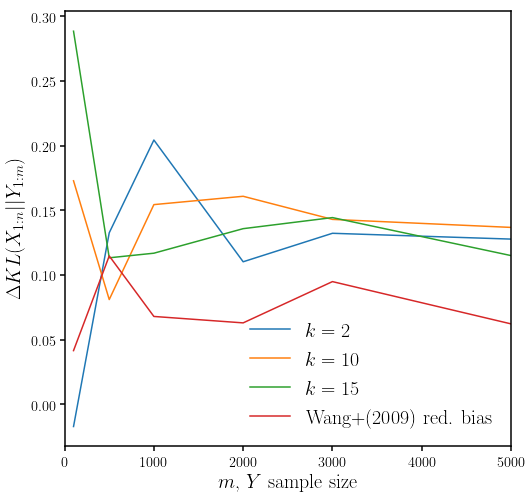

In [17]:
# KL(X||Y) convergence plot for SKL KL estimate
fig = plt.figure(figsize=(8,8))
sub = fig.add_subplot(111)
sub.plot(m_s, [np.average(pkKLyx_skl_k2[i]) - np.average(ref_pkKLyx_skl_k2[i]) for i in range(len(m_s))], c='C0', label='$k=2$')
sub.plot(m_s, [np.average(pkKLyx_skl_k10[i]) - np.average(ref_pkKLyx_skl_k10[i]) for i in range(len(m_s))], c='C1', label='$k=10$')
sub.plot(m_s, [np.average(pkKLyx_skl_k15[i]) - np.average(ref_pkKLyx_skl_k15[i]) for i in range(len(m_s))], c='C2', label='$k=15$')
sub.plot(m_s, [np.average(pkKLyx_redBias[i]) - np.average(ref_pkKLyx_redBias[i]) for i in range(len(m_s))], c='C3', label='Wang+(2009) red. bias')
sub.legend(loc='lower right', fontsize=20)
sub.set_xlabel('$m$, $Y$ sample size', fontsize=20)
sub.set_xlim([0., 5e3])
sub.set_ylabel('$\Delta KL(X_{1:n} || Y_{1:m})$', fontsize=20)

Now for GMF!

In [18]:
X_gmf = NG.X_gmf_all()
X_res, _ = NG.meansub(X_gmf)
X_w, W = NG.whiten(X_res)
C_x = np.cov(X_w.T)

In [20]:
n, dim = X_gmf.shape
print("%i dimensional data with %i samples" % (dim, n))

8 dimensional data with 20000 samples


In [21]:
# reference Gaussian X 
X_ref = mvn(np.zeros(dim), C_x, size=n)

In [24]:
gmfKLxy_skl_k10, gmfKLxy_skl_k15, gmfKLxy_redBias = [], [], []

for m in m_s: 
    skl_k10 = Dxy_SKL(X_w, m, 10, div_func='kl', n_sample=10, Cov=C_x)
    skl_k15 = Dxy_SKL(X_w, m, 15, div_func='kl', n_sample=10, Cov=C_x)
    skl_rb = KLxy_redBias(X_w, m, n_sample=10, Cov=C_x)
    
    gmfKLxy_skl_k10.append(skl_k10)
    gmfKLxy_skl_k15.append(skl_k15)    
    gmfKLxy_redBias.append(skl_rb)

In [ ]:
ref_gmfKLxy_skl_k10, ref_gmfKLxy_skl_k15, ref_gmfKLxy_redBias = [], [], []

for m in m_s: 
    skl_k10 = Dxy_SKL(X_ref, m, 10, div_func='kl', n_sample=10, Cov=C_x)
    skl_k15 = Dxy_SKL(X_ref, m, 15, div_func='kl', n_sample=10, Cov=C_x)
    skl_rb = KLxy_redBias(X_ref, m, n_sample=10, Cov=C_x)
    
    ref_gmfKLxy_skl_k10.append(skl_k10)
    ref_gmfKLxy_skl_k15.append(skl_k15)    
    ref_gmfKLxy_redBias.append(skl_rb)